# Image Caption Generation

## Colab Notebook Connected With Drive

# Import Required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Flicker8k


/content/drive/MyDrive/Flicker8k


In [3]:
!unzip Flicker8k_Dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [4]:
import numpy as np      # Provides support for efficient numerical operations.
from PIL import Image   # Handle image processing tasks.
import os               # Allows interaction with the operating system by providing functions for file/folder manipulation.
import pickle           # Store NumPy features
from pickle import dump, load   # Enables saving/loading data structures like models or tokenizers.
from keras.applications.xception import Xception  # Which is a pre-trained CNN, along with preprocessing functions specific to Xception.
from keras.applications.xception import preprocess_input
from keras.preprocessing import image  # For loading imgs and img processing
from keras.utils import load_img
from keras.utils import img_to_array   # Applying image transformations
from keras.preprocessing.text import Tokenizer  # For text preprocessing/tokenization
from keras.utils import pad_sequences    # Importing utility functions related to sequence padding, one-hot encoding
from keras.utils import to_categorical, plot_model   #          of labels, and embedding layer in Keras.
from keras.layers import add          # Function for merging layers.
from keras.models import Model, load_model      # Creating/loading models.
from keras.layers import Input, Dense, LSTM, Embedding, Dropout   # Building the neural network model.
from tqdm import tqdm          # Provides a progress bar visualization during iterations.
from nltk.translate.bleu_score import corpus_bleu     # calculate the BLEU score for a corpus of multiple sentences rather than individual sentences
import matplotlib.pyplot as plt

# Loading The Data

In [5]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Flicker8k'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Flicker8k/Images/2844747252_64567cf14a.jpg
/content/drive/MyDrive/Flicker8k/Images/2844846111_8c1cbfc75d.jpg
/content/drive/MyDrive/Flicker8k/Images/2844963839_ff09cdb81f.jpg
/content/drive/MyDrive/Flicker8k/Images/2845246160_d0d1bbd6f0.jpg
/content/drive/MyDrive/Flicker8k/Images/2845691057_d4ab89d889.jpg
/content/drive/MyDrive/Flicker8k/Images/2845845721_d0bc113ff7.jpg
/content/drive/MyDrive/Flicker8k/Images/2846037553_1a1de50709.jpg
/content/drive/MyDrive/Flicker8k/Images/2846785268_904c5fcf9f.jpg
/content/drive/MyDrive/Flicker8k/Images/2846843520_b0e6211478.jpg
/content/drive/MyDrive/Flicker8k/Images/2847514745_9a35493023.jpg
/content/drive/MyDrive/Flicker8k/Images/2847615962_c330bded6e.jpg
/content/drive/MyDrive/Flicker8k/Images/2847859796_4d9cb0d31f.jpg
/content/drive/MyDrive/Flicker8k/Images/2848266893_9693c66275.jpg
/content/drive/MyDrive/Flicker8k/Images/2848571082_26454cb981.jpg
/content/drive/MyDrive/Fl

# Feature Extraction

In [6]:
# Load the Model
model = Xception()

# Restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

91884032/91884032 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

## Extract the image features

In [7]:
# extract features from image
features = {}
directory = os.path.join('/content/drive/My Drive/Flicker8k/Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Xception
    # subtracting mean pixel values specific to Xception network
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

    '''After running this cell, you will have a dictionary (features)
        where each key represents an image ID, and each value represents
        its corresponding extracted feature vector obtained from the Xception model'''


100%|██████████| 8091/8091 [11:37<00:00, 11.60it/s]


In [8]:

pickle.dump(features, open(os.path.join('/content/drive/My Drive/Flicker8k','features.pkl'), 'wb'))    #  saves the Python object called "features" into a binary file at the specified location

'''After executing these lines of code, your "features" object will be saved as a pickled binary file named "features.pkl" at the specified location (file_path).'''

'After executing these lines of code, your "features" object will be saved as a pickled binary file named "features.pkl" at the specified location (file_path).'

In [9]:
with open('/content/drive/My Drive/Flicker8k/features.pkl', 'rb') as read:
    loaded_features = pickle.load(read)

'''After executing this code snippet, you should have your features stored in loaded_features, ready for further processing or analysis.'''

'After executing this code snippet, you should have your features stored in loaded_features, ready for further processing or analysis.'

## Load caption data

In [10]:
with open(os.path.join('/content/drive/My Drive/Flicker8k', 'captions.txt'), 'rb') as cap:
    next(cap)
    captions_doc = cap.read()

In [11]:
mapping = {}
for line in tqdm(captions_doc.decode('UTF-8').split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption.strip())

'''After executing this code, you will have a dictionary named mapping, where each image ID is mapped to a list of its corresponding captions.'''

100%|██████████| 40456/40456 [00:00<00:00, 602368.38it/s]


'After executing this code, you will have a dictionary named mapping, where each image ID is mapped to a list of its corresponding captions.'

In [12]:
len(mapping)

8091

# Cleaning Data

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')  # replaces consecutive whitespace characters with a single space.
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            print(caption)
            captions[i] = caption
clean(mapping)

'''After executing this function on your input data, it will update and modify your original mapping by cleaning and preprocessing all captions stored within it.'''

Streaming output truncated to the last 5000 lines.
startseq dog is jumping over log in wooded area while carrying another log endseq
startseq dog with stick in his mouth jumps over fallen tree in the forest endseq
startseq dog carries stick and jumps over log endseq
startseq the dog carries stick and jumps over log in the woods endseq
startseq the dog jumps over the log with stick in its mouth endseq
startseq black and brown dog is running between two cement barriers with snow endseq
startseq dog runs down the cold aisle endseq
startseq black and tan small dog walking with perked ears endseq
startseq "the black and brown dog walks toward the camera in an enclosed snowy area ." endseq
startseq the brown and black dog is running through snowy street endseq
startseq furry dog is running through doorway leading to plants endseq
startseq "a furry tan dog is outside on patio ." endseq
startseq "a short furry dog stands on brick floor in front of group of potted plants ." endseq
startseq very

'After executing this function on your input data, it will update and modify your original mapping by cleaning and preprocessing all captions stored within it.'

In [14]:
mapping['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40455

# Preprocessing of text data

In [16]:
# Tokenaization
tokenizer = Tokenizer()   # creates an instance of the Tokenizer class
tokenizer.fit_on_texts(all_captions)   # fits the tokenizer on a list or array
vocab_size = len(tokenizer.word_index) + 1


'''After executing these lines, you will have a tokenizer object (tokenizer) that has been fitted on your captions data and a variable (vocab_size)
representing the total number of unique words found in your captions dataset plus one.
Tokenization is an important preprocessing step used to convert text into numerical representations suitable for
machine learning models, such as neural networks, where input data needs to be represented as numbers rather than raw text.'''

'After executing these lines, you will have a tokenizer object (tokenizer) that has been fitted on your captions data and a variable (vocab_size)\nrepresenting the total number of unique words found in your captions dataset plus one.\nTokenization is an important preprocessing step used to convert text into numerical representations suitable for\nmachine learning models, such as neural networks, where input data needs to be represented as numbers rather than raw text.'

In [17]:
with open('/content/drive/My Drive/Flicker8k/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# Getting maximum length
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

'''After executing these lines, you will have two lists: 'train', containing approximately 90% of your original image IDs for
training purposes, and 'test', containing approximately 10% for testing/evaluation purposes.'''

"After executing these lines, you will have two lists: 'train', containing approximately 90% of your original image IDs for\ntraining purposes, and 'test', containing approximately 10% for testing/evaluation purposes."

In [20]:
# create data generator to get data in batch (avoids session crash)
def Data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

'''This data generator enables you to generate batches of image features, input sequences, and output labels on-the-fly while training your
model in order to avoid memory issues or session crashes caused by loading all data into memory at once.'''

'This data generator enables you to generate batches of image features, input sequences, and output labels on-the-fly while training your\nmodel in order to avoid memory issues or session crashes caused by loading all data into memory at once.'

# Model Creation (Defining the CNN & RNN Model)

In [21]:
inputs1 = Input(shape=(2048,))    # Creating an input layer, each input has 2048 dimensions
fe1 = Dropout(0.4)(inputs1) # 40% of the inputs will be randomly set to 0 during training to reduce overfitting.
fe2 = Dense(256, activation='relu')(fe1) # This adds a fully connected dense layer with 256 units and ReLU activation function on top of the previous layer fe1.

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)  # Utilizes Long Short-Term Memory (LSTM), with 256 memory cells/neurons applied on se2.

# decoder model
decoder1 = add([fe2, se3])  # Adds both fe2 and se3 layers element-wise together as part of decoder architecture.
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # The final output layer consists of a dense layer with vocab_size units
                                                            # (representing the number of classes or vocabulary size) and softmax activation function to obtain
                                                             # probability distribution over different classes/words.


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# visualize the model
plot_model(model, show_shapes=True)

'''this code snippet provides an overview of building a neural network using Keras but does not include details about data preprocessing or
            training steps which may be required before fitting this model to actual data.'''

'this code snippet provides an overview of building a neural network using Keras but does not include details about data preprocessing or\n            training steps which may be required before fitting this model to actual data.'

# Training The Model

Now let's train our model

In [22]:

epochs = 25
batch_size = 32
# Calculate number of steps per epoch
steps = len(train) // batch_size   #  Back propagation and fetch the next data

for i in range(epochs):
    generator = Data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1) # verbose=1 -> controls whether progress updates are displayed during training.

'''This setup allows you to train your model on large datasets efficiently by processing smaller batches at once instead of loading all data into memory simultaneously.
                    - Loss function decreases gradually over the iterations,
                    - Increase the no. of epochs for better results,
                    - Assign the no. of epochs and batch size accordingly for quicker results'''

227/227 [==============================] - 63s 276ms/step - loss: 1.9831


'This setup allows you to train your model on large datasets efficiently by processing smaller batches at once instead of loading all data into memory simultaneously.\n                    - Loss function decreases gradually over the iterations,\n                    - Increase the no. of epochs for better results,\n                    - Assign the no. of epochs and batch size accordingly for quicker results'

Saving the model

In [23]:
model.save('/content/drive/My Drive/Flicker8k'+'/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
def index_to_word(integer, tokenizer): # integer -> the index to be converted
                                       # tokenizer -> the object containing the word-to-index mapping
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

'''This function can be useful when working with natural language processing tasks or
text data where we want to map numerical indices back to their original words using a pre-built dictionary or tokenizer.
Convert the predicted index from the model into a word'''

'This function can be useful when working with natural language processing tasks or\ntext data where we want to map numerical indices back to their original words using a pre-built dictionary or tokenizer.\nConvert the predicted index from the model into a word'

In [25]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):  # this determines the maximum length of generated captions).
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0) # represents probabilities across different words in vocabulary.
        # get index with high probability
        yhat = np.argmax(yhat) # The index with highest probability (argmax) is selected as the predicted word index.
        # convert index to word
        word = index_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    in_text = in_text.replace('startseq', '').replace('endseq', '')
    return in_text.strip()

'''Generates captions for images using a pre-trained model, tokenizer, and maximum sequence length using (predict_caption) function'''

'Generates captions for images using a pre-trained model, tokenizer, and maximum sequence length using (predict_caption) function'

In [26]:
# validate with test data
actual, predicted = list(), list() # Score actual captions and predicted captions for each image in the test dataset
# This loop iterates over each image in the test dataset (represented by test) using the tqdm function to display a progress bar.
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # actual and predicted captions are split into individual words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))) # unigram precision
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))) # bigram precision

'''this code evaluates how well a caption generation model performs on test data by comparing its
generated captions to reference or ground truth captions using BLEU scores.'''


100%|██████████| 810/810 [14:39<00:00,  1.09s/it]


BLEU-1: 0.412412
BLEU-2: 0.245439


'this code evaluates how well a caption generation model performs on test data by comparing its\ngenerated captions to reference or ground truth captions using BLEU scores.'

# Visualization

In [27]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/drive/My Drive/Flicker8k', "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual caption : ')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('Predicted caption : ')
    print(y_pred)
    plt.imshow(image)

Actual caption : 
startseq group is sitting around snowy crevasse endseq
startseq group of people sit atop snowy mountain endseq
startseq group of people sit in the snow overlooking mountain scene endseq
startseq five children getting ready to sled endseq
startseq five people are sitting together in the snow endseq
Predicted caption : 
man and woman are hiking up snowy hill


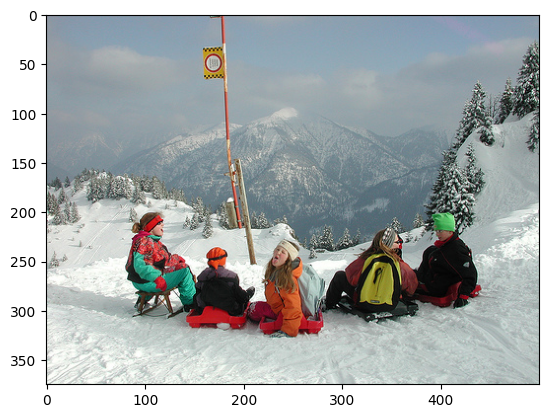

In [28]:
generate_caption('99171998_7cc800ceef.jpg')

Actual caption : 
startseq group of children run footrace in the snow endseq
startseq group of young boys race on snowy day endseq
startseq school kids racing in the snow endseq
startseq the children are running in the snow with fences in the background endseq
startseq the young runners are racing through the snow endseq
Predicted caption : 
two hockey players are jumping over snow covered hill


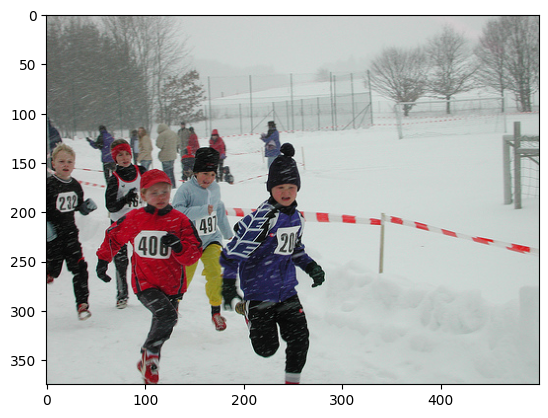

In [29]:
generate_caption("72218201_e0e9c7d65b.jpg")

Actual caption : 
startseq man at the top of mountain with beautiful view in the background endseq
startseq man is sitting on snowbank endseq
startseq man on snowy peak endseq
startseq person in red snow gear is kneeling on snowy ridge under blue sky endseq
startseq mountain climber in red suit poses on snowy peak with mountains in the background endseq
Predicted caption : 
man in blue and white top is snowboarding


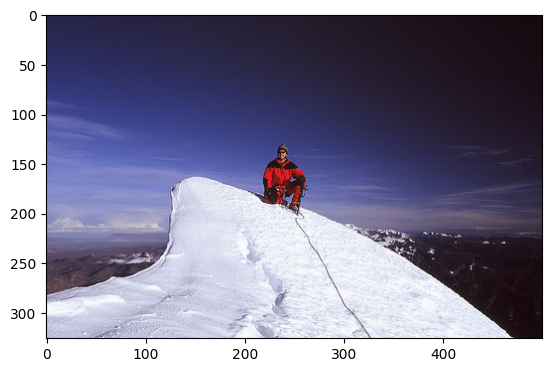

In [30]:
generate_caption("55473406_1d2271c1f2.jpg")

Actual caption : 
startseq grey bird stands majestically on beach while waves roll in endseq
startseq large bird stands in the water on the beach endseq
startseq tall bird is standing on the sand beside the ocean endseq
startseq water bird standing at the ocean 's edge endseq
startseq white crane stands tall as it looks out upon the ocean endseq
Predicted caption : 
bird flies over the water


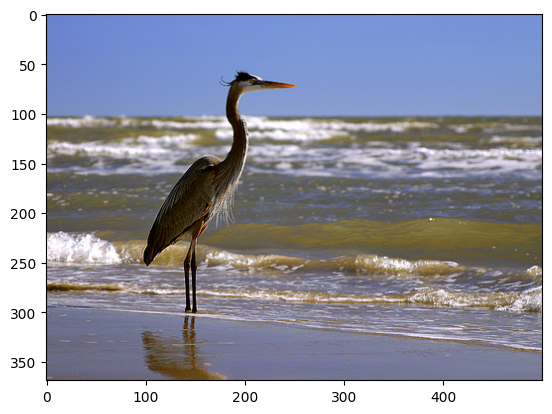

In [31]:
generate_caption("99679241_adc853a5c0.jpg")